# Chapter 13: Characterization

For additional context see chapter 13 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [30]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr

%matplotlib inline

## Get the data

This chapter uses two datasets. The first dataset is the sales for two sales regions called `sales-by-regions.csv`. The second dataset is Shewhart's electrical resistance measurements called `shewharts-resistance-measurements.csv`.

In [31]:
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

### Get the sales data

In [32]:
# Sales dataset url
sales_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/sales-by-regions.csv'

# Get data
sales_df = get_data(sales_url)

# Make 'Year' column dtype string
sales_df['Month'] = sales_df['Month'].astype('string')

# Show dataframe
sales_df.head()

Month  East Region  West Region
0   Jan         10.7          6.9
1   Feb         13.0         11.3
2   Mar         11.4          9.3
3   Apr         11.5          9.8
4   May         12.5         18.7

In [33]:
# Split sales_df according to region
df_east = sales_df[['Month', 'East Region']].copy()
df_west = sales_df[['Month', 'West Region']].copy()

# Rename the columns for clarity (optional)
df_east.columns = ['Month', 'Sales']
df_west.columns = ['Month', 'Sales']

# Calculate moving ranges for both regions
df_east['Moving Ranges'] = abs(df_east['Sales'].diff())
df_west['Moving Ranges'] = abs(df_west['Sales'].diff())

# Create list of dataframes
df_list = [df_east, df_west]
plot_label_names = ['East Region','West Region']

### Get the resistance measurements

In [34]:
# Sales dataset url
resistance_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/shewharts-resistance-measurements.csv'

# Get data
resistance_df = get_data(resistance_url)

# Make 'Value' column dtype string
resistance_df['Value'] = resistance_df['Value'].astype('string')

# Drop 'Units' column
resistance_df = resistance_df.drop('Units', axis=1)

# Show dataframe
resistance_df.head()

Stage Value  Resistance
0  Initial     1        5045
1  Initial     2        4350
2  Initial     3        4350
3  Initial     4        3975
4  Initial     5        4290

In [35]:
# Split resistance_df by stage
initial_df = resistance_df[resistance_df['Stage'] == 'Initial']

additional_df = resistance_df[resistance_df['Stage'] == 'Additional'].reset_index(drop=True)

## Figure 13.2: XmR charts of sales regions

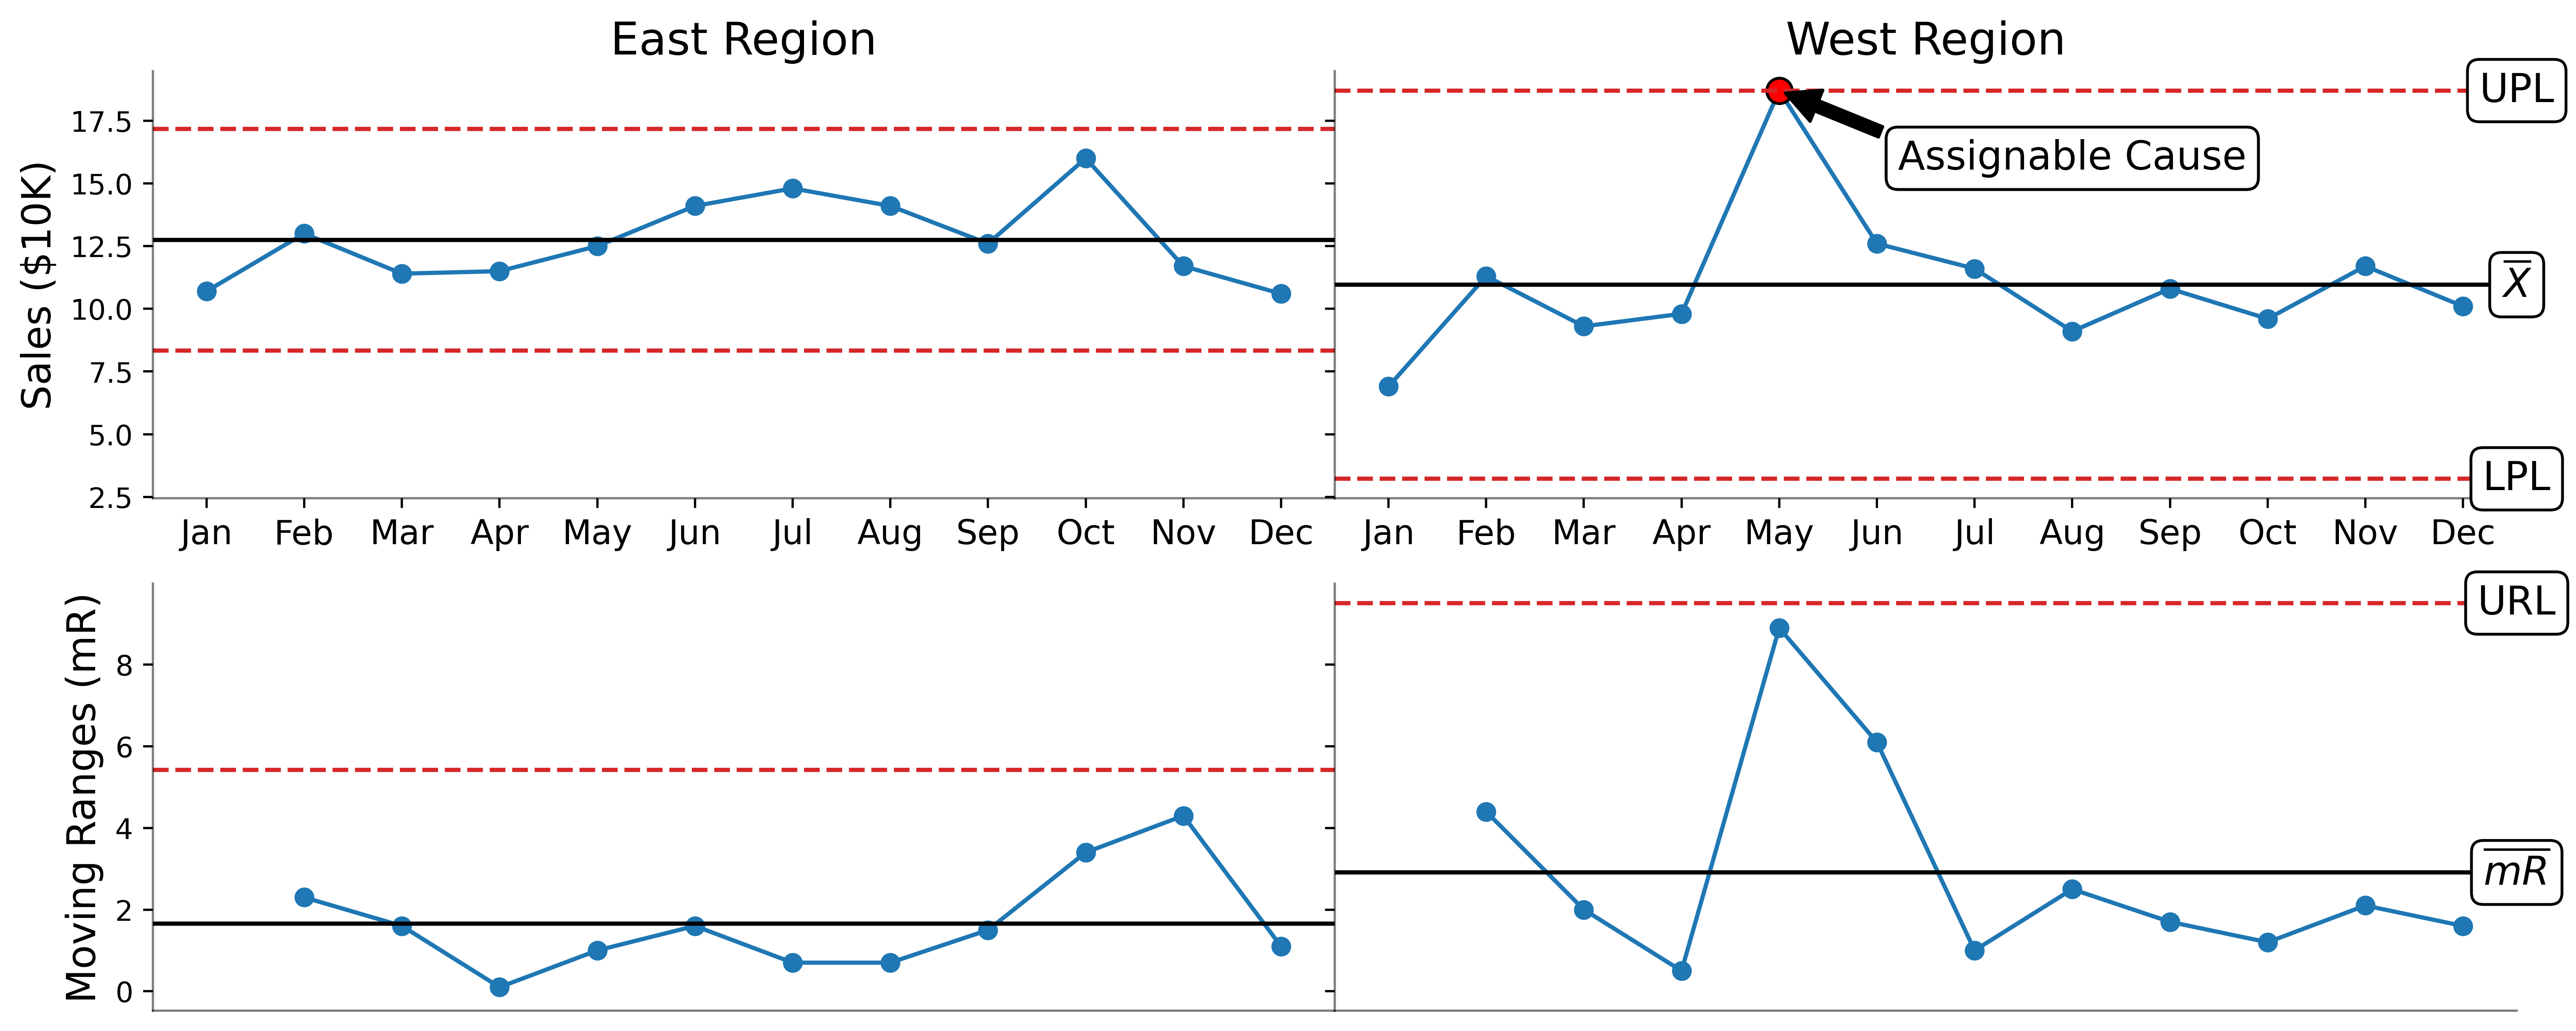

In [36]:
# Specify round_value
round_value = 2
# Specify condition
condition = 'Sales'
labels = 'Month'

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, plot_label_names)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value).copy()
    moving_range.iloc[0] = np.nan
    xticks = df[labels]

    # Specify scaling factors
    C1 = 2.660
    C2 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (C1 * average_mR), round_value)
    LPL = round(max(mean - (C1 * average_mR), 0), round_value)
    URL = round(C2 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })

    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label, fontsize=16)

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(LPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='-')
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), 1)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center', fontsize=12)

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')
    
    # Offset moving range by 1 relative to the individual values
    for xi, yi in zip(labels, moving_range):
        if np.isnan(yi):
            axes[1, idx].plot(xi, 0, marker='x', color='white', markersize=0)

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='tab:red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='-')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Sales ($10K)', fontsize=14)
    axes[1, 0].set_ylabel('Moving Ranges (mR)', fontsize=14)
    
    # Remove yticks
#     axes[0, 0].set_yticks([])
#     axes[1, 0].set_yticks([])
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

    # Add labels to 2nd and 4th plots
    if idx == 1:
        axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)

    if idx == 1:
        axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                          color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)

    # Add annotations
    axes[0,1].annotate('Assignable Cause', 
         xy=(4,18.7),  # x, y coordinates of the annotation
         xytext=(7,16),  # Position of the text
         fontsize=14,
         color='black',
         ha='center',
         va='center',
         arrowprops=dict(facecolor='black', shrink=0.05),
         bbox=dict(facecolor='white',boxstyle='round',edgecolor='black'))

    # Remove ticks on xticks for moving ranges
    axes[1, idx].set_xticks([])
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)

# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
stats_df = pd.DataFrame(stats_list)

## Figure 13.4: A predictable process

In [37]:
# Seed for reporducibility
np.random.seed(43)

# Example data for D1, D2, D3, and D4
predictable_1 = np.random.normal(10, 1.5, 100)
predictable_2 = np.random.normal(10, 1.3, 100)
predictable_3 = np.random.normal(10, 1.3, 100)
predictable_4 = np.random.normal(10, 1.3, 100)

# Calculate process limits for D1
mean = predictable_1.mean()
mR = abs(pd.Series(predictable_1).diff())
AmR = mR.mean()

UPL = mean + (2.660*AmR)
LPL = mean - (2.660*AmR)

data_list = [predictable_1, predictable_2, predictable_3, predictable_4]
specific_ticks = ['Day 1', 'Day 2', 'Day 3', 'Day 4']

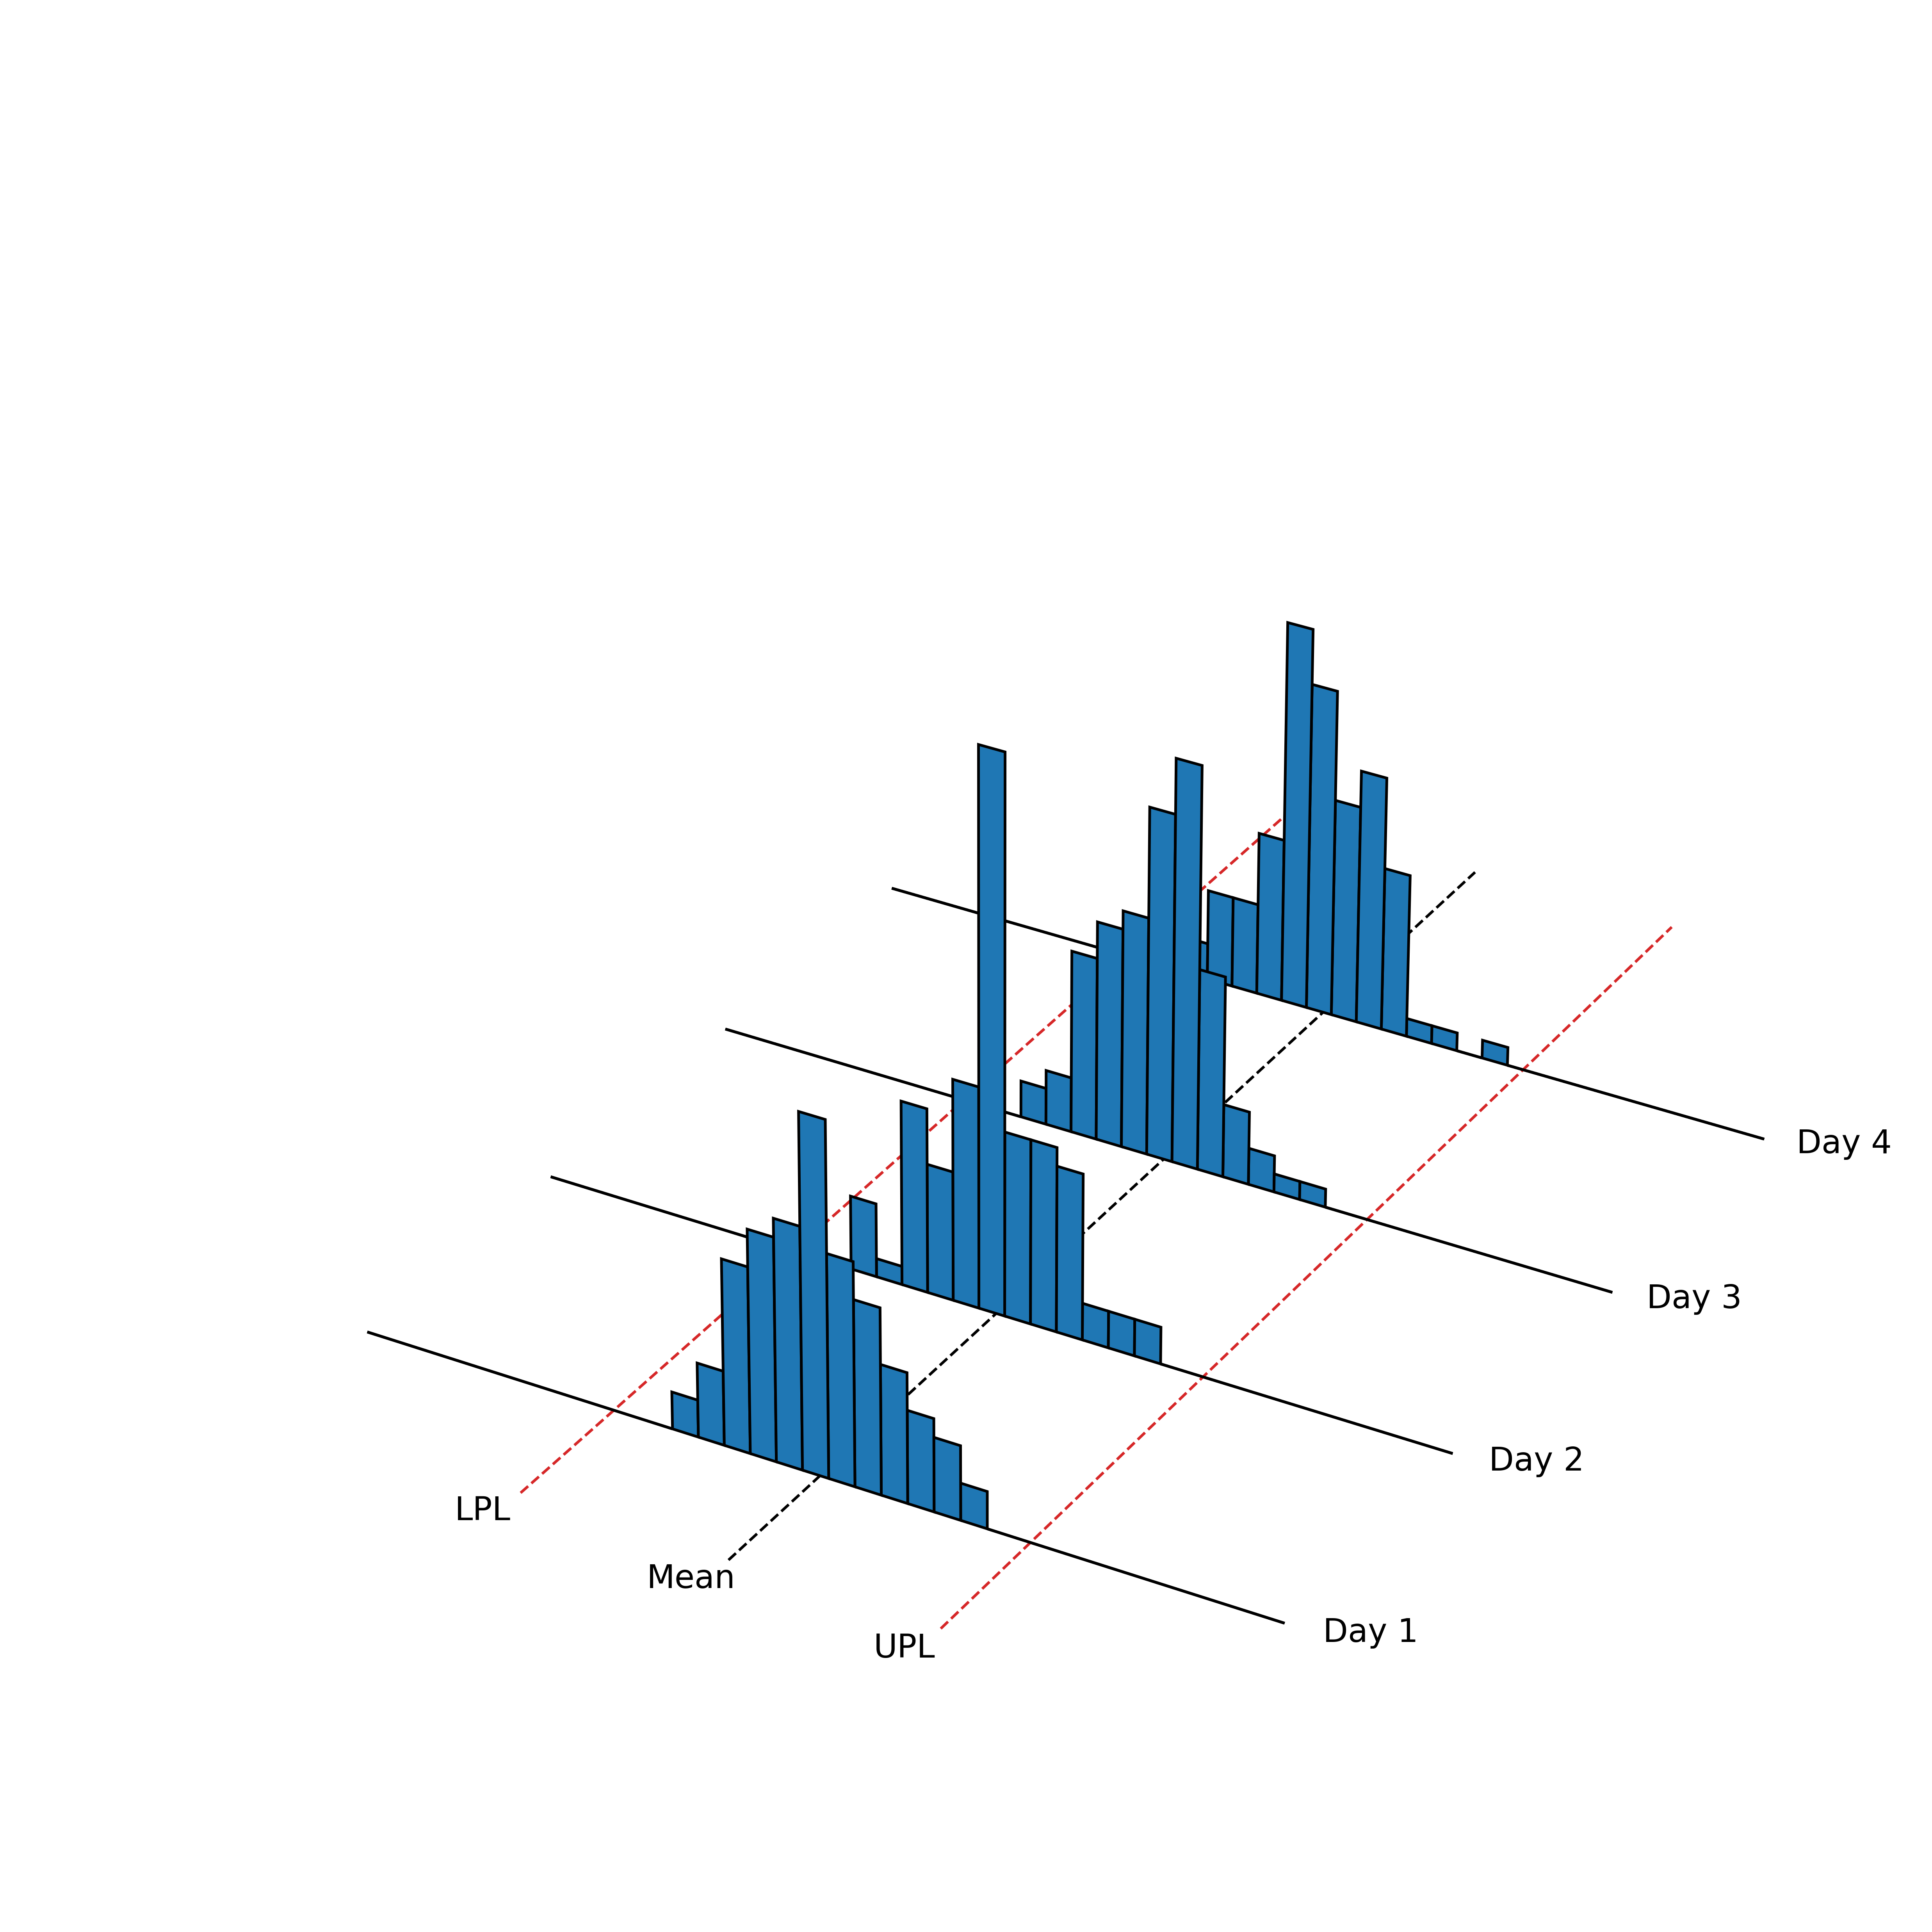

In [38]:
# ---------- CONFIGURATION ----------
fig = plt.figure(figsize=(10, 12), dpi=500)
ax = fig.add_subplot(111, projection='3d')

spacing      = 0.05               # Vertical offset between histograms
x_min, x_max = 0, 20               # X-axis range
bar_bins     = 35
bar_color    = 'tab:blue'
line_color   = 'black'
limit_color  = 'tab:red'

# ---------- DRAW HISTOGRAMS ----------
for i, (data, label) in enumerate(zip(data_list, specific_ticks)):
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bar_bins, range=(x_min, x_max))
    bin_centers     = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bar_width       = bin_edges[1] - bin_edges[0]

    # Offset each histogram in Y
    y_offset = i * spacing
    ax.bar(
        bin_centers, hist, zs=y_offset, zdir='y',
        width=bar_width, color=bar_color,
        alpha=1, edgecolor='black'
    )

    # Add text labels to the right of each histogram
    ax.text(
        22.75, y_offset, 1.75, label,
        color='black', fontsize=12,
        ha='right', va='center'
    )

# ---------- ADD REFERENCE LINES ----------
def add_vertical_line(x, color, label=None, style='--'):
    """Add vertical line with optional label below the axis."""
    ax.plot([x, x], [-0.025, 0.2], [0, 0], color=color, linewidth=1, ls=style)
    if label:
        ax.text(x, -0.035, 0, label, color='black', fontsize=12,
                ha='center', va='bottom')

add_vertical_line(mean, line_color, label='Mean')
add_vertical_line(UPL,  limit_color, label='UPL')
add_vertical_line(LPL,  limit_color, label='LPL')

# ---------- AXES SETTINGS ----------
ax.set_xlabel('Quality Characteristic')
ax.set_ylabel('Time')
ax.set_zlabel('Frequency')

# Y-ticks at histogram positions
y_positions = [i * spacing for i in range(len(specific_ticks))]
ax.set_yticks(y_positions)
ax.set_yticklabels(specific_ticks)

# Extend Y-axis limits and remove grids
ax.set_ylim(-spacing, len(specific_ticks) * spacing)
ax.grid(False)

# Scale Y-axis for rectangular shape
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax),
                             np.diag([1.0, 1.5, 0.75, 1.0]))

# Remove all axes/ticks/spines for clean 3D view
ax.set_axis_off()

# ---------- DISPLAY ----------
plt.tight_layout()
plt.show()

## Figure 13.5: An unpredictable process

In [39]:
# Seed for reproducibility
np.random.seed(43)

# Example data for D1, D2, D3, and D4
unpredictable_1 = np.random.normal(10, 1.5, 100)
unpredictable_2 = np.random.normal(13, 1.1, 100)
unpredictable_3 = np.random.normal(7, 1.25, 100)
unpredictable_4 = np.random.normal(10, 2.25, 100)

# Calculate process limits for D1
mean = unpredictable_1.mean()
mR = abs(pd.Series(unpredictable_1).diff())
AmR = mR.mean()

# Calculate UPL and LPL
UPL = mean + (2.660*AmR)
LPL = mean - (2.660*AmR)

# Create data list
data_list = [unpredictable_1, 
             unpredictable_2, 
             unpredictable_3, 
             unpredictable_4]

# Create tick label list
specific_ticks = ['Day 1', 'Day 2', 'Day 3', 'Day 4']

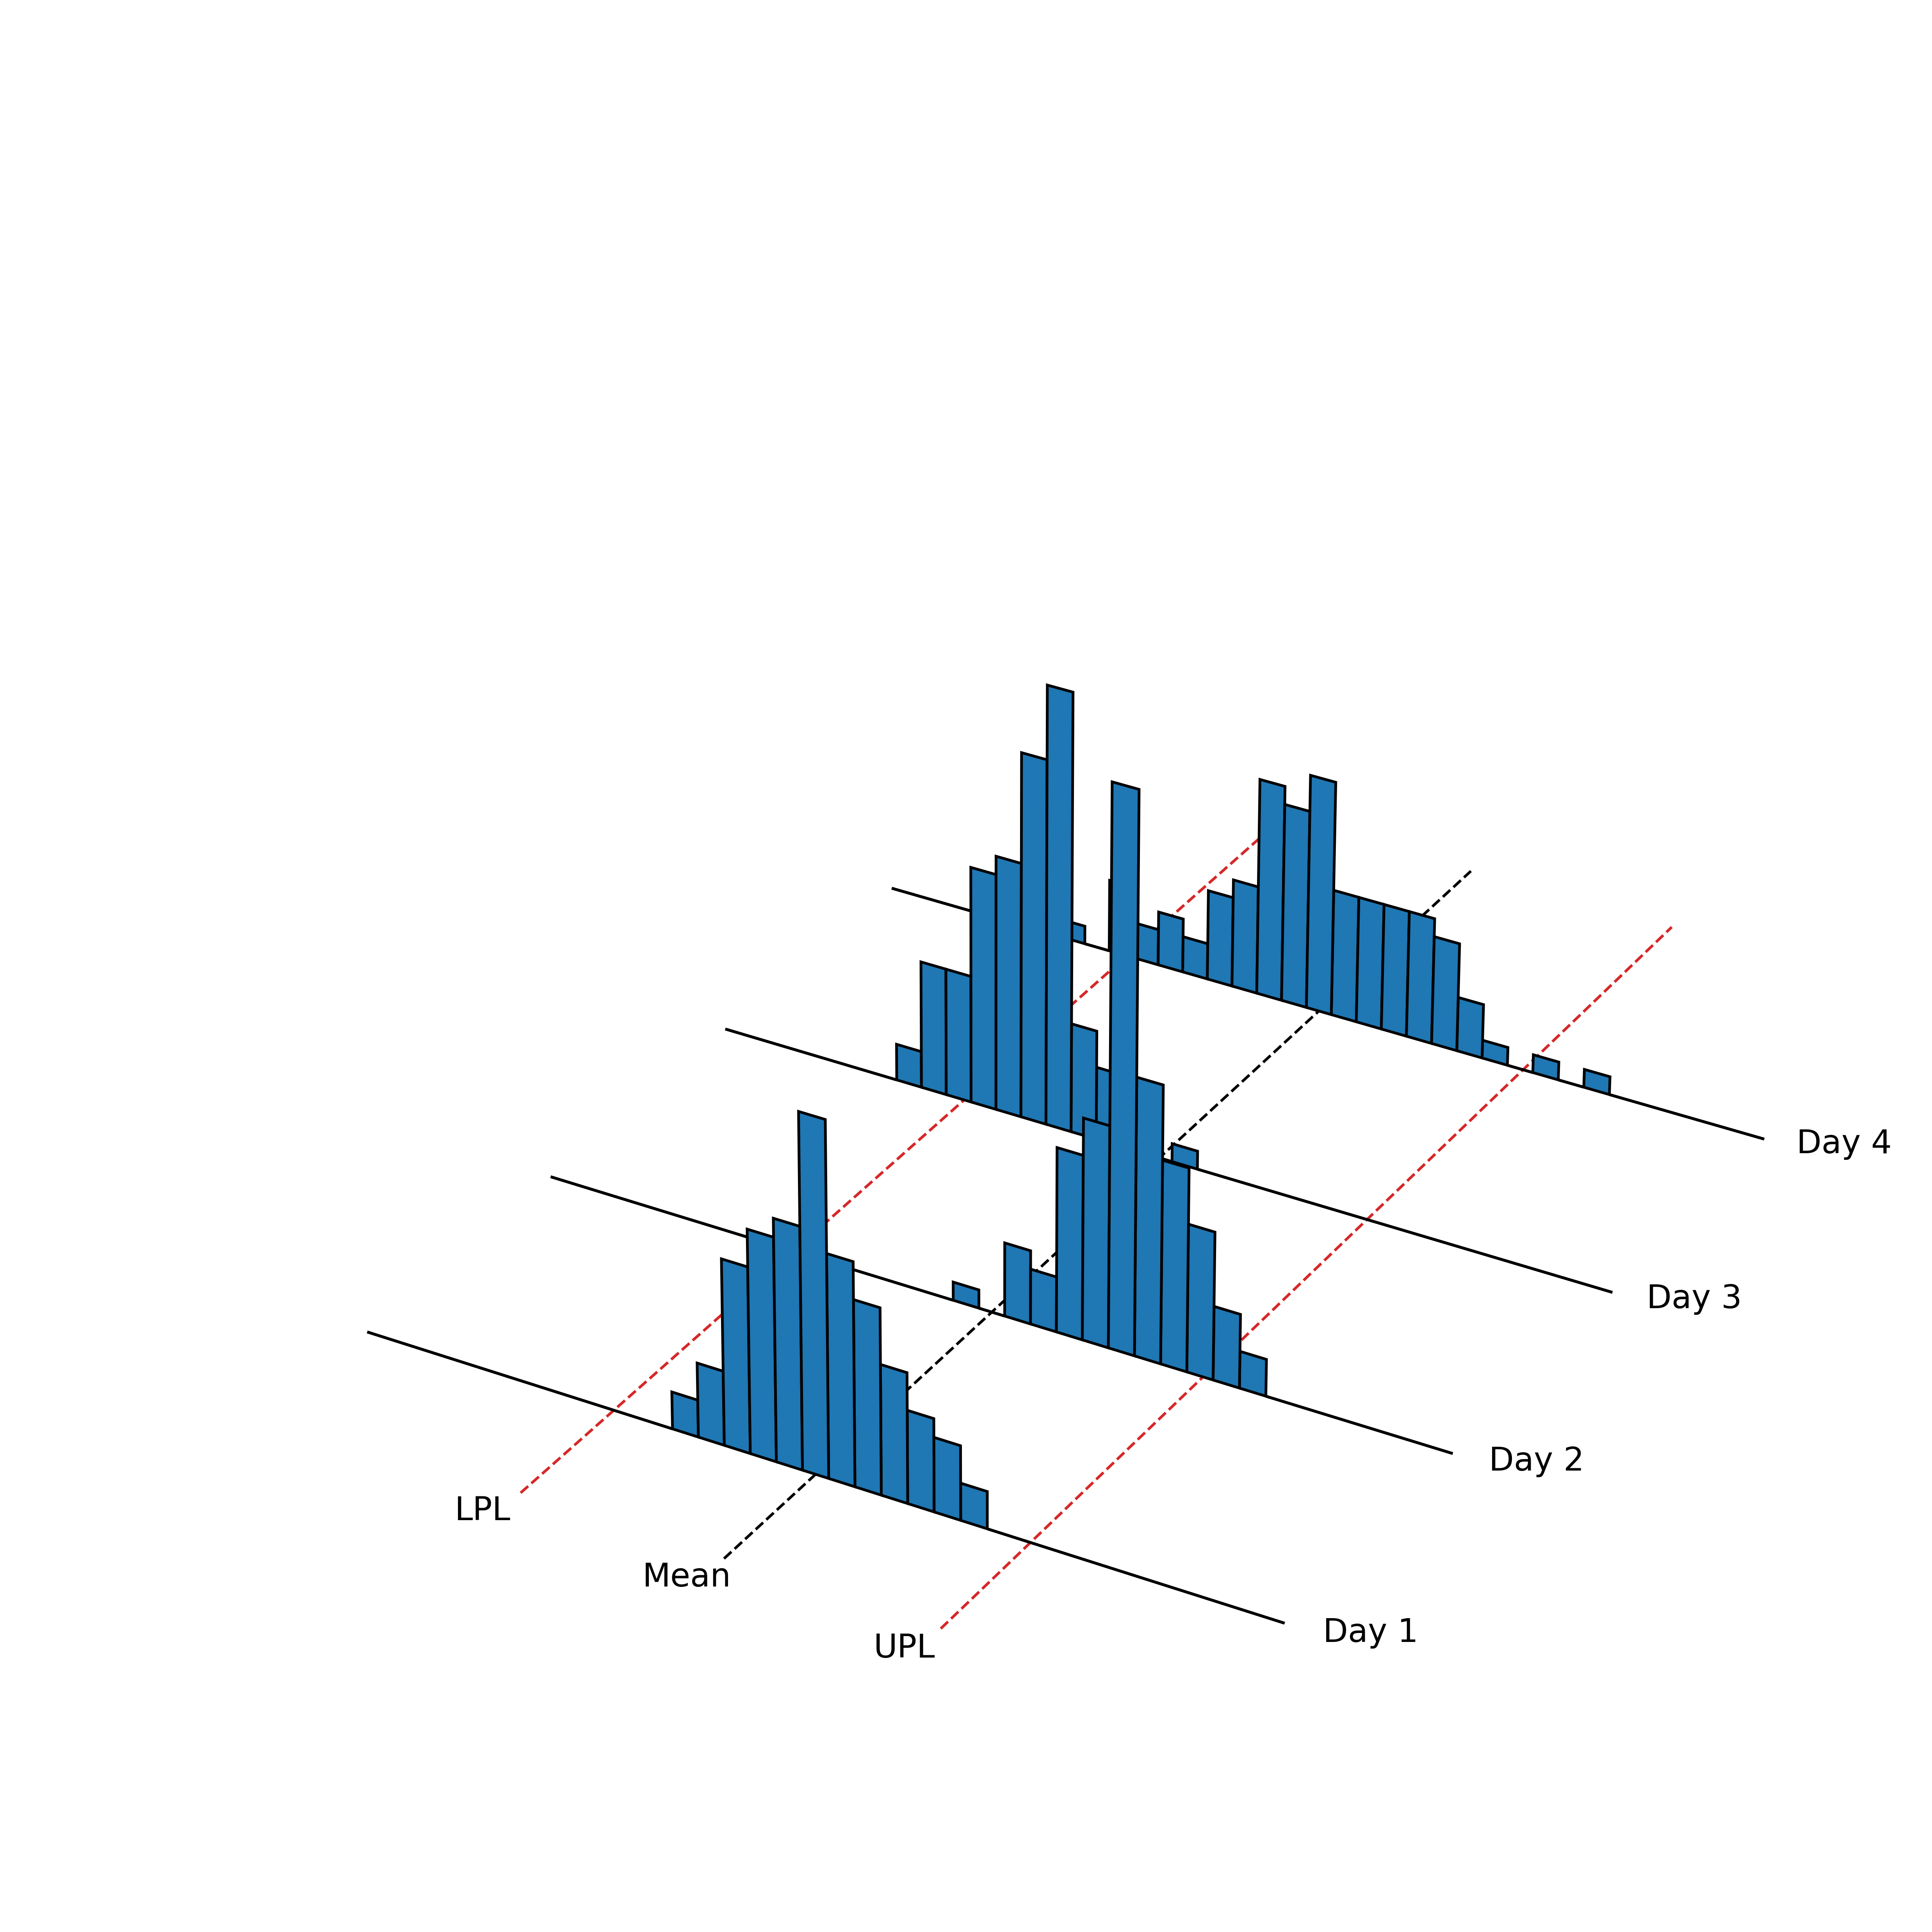

In [40]:
# ---------- CONFIGURATION ----------
fig = plt.figure(figsize=(10, 12), dpi=500)
ax = fig.add_subplot(111, projection='3d')

spacing = 0.05                    # Vertical offset between histograms
x_min, x_max = 0, 20               # X-axis range
bar_bins = 35
bar_color = 'tab:blue'
line_color = 'black'
limit_color = 'tab:red'

# ---------- DRAW HISTOGRAMS ----------
for i, (data, label) in enumerate(zip(data_list, specific_ticks)):
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bar_bins, range=(x_min, x_max))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bar_width = bin_edges[1] - bin_edges[0]

    # Offset each histogram in Y
    y_offset = i * spacing
    ax.bar(
        bin_centers, hist, zs=y_offset, zdir='y', width=bar_width,
        color=bar_color, alpha=1, edgecolor='black'
    )

    # Label each histogram on the Y axis
    ax.text(
        22.75, y_offset, 1.75, label,
        color='black', fontsize=12, ha='right', va='center'
    )

# ---------- ADD REFERENCE LINES ----------
def add_vertical_line(x, color=line_color, label=None, style='--'):
    """Add vertical reference line & optional label below axis."""
    ax.plot([x, x], [-0.025, 0.2], [0, 0], color=color, linewidth=1, ls=style)
    if label:
        ax.text(x, -0.035, 0, label, color='black', fontsize=12,
                ha='center', va='bottom')

add_vertical_line(10, line_color, label='Mean', style='--')
add_vertical_line(UPL, limit_color, label='UPL')
add_vertical_line(LPL, limit_color, label='LPL')

# ---------- AXES & TICKS ----------
ax.set_xlabel('Quality Characteristic')
ax.set_ylabel('Time')
ax.set_zlabel('Frequency')

y_positions = [i * spacing for i in range(len(specific_ticks))]
ax.set_yticks(y_positions)
ax.set_yticklabels(specific_ticks)

ax.set_ylim(-spacing, len(specific_ticks) * spacing)
ax.grid(False)

# Scale the Y axis to make plots more rectangular
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.5, 0.75, 1.0]))

# Remove all axes spines/ticks for a cleaner 3D look
ax.set_axis_off()

# ---------- DISPLAY ----------
plt.tight_layout()
plt.show()

## Figure 13.7: Run chart of resistance measurements

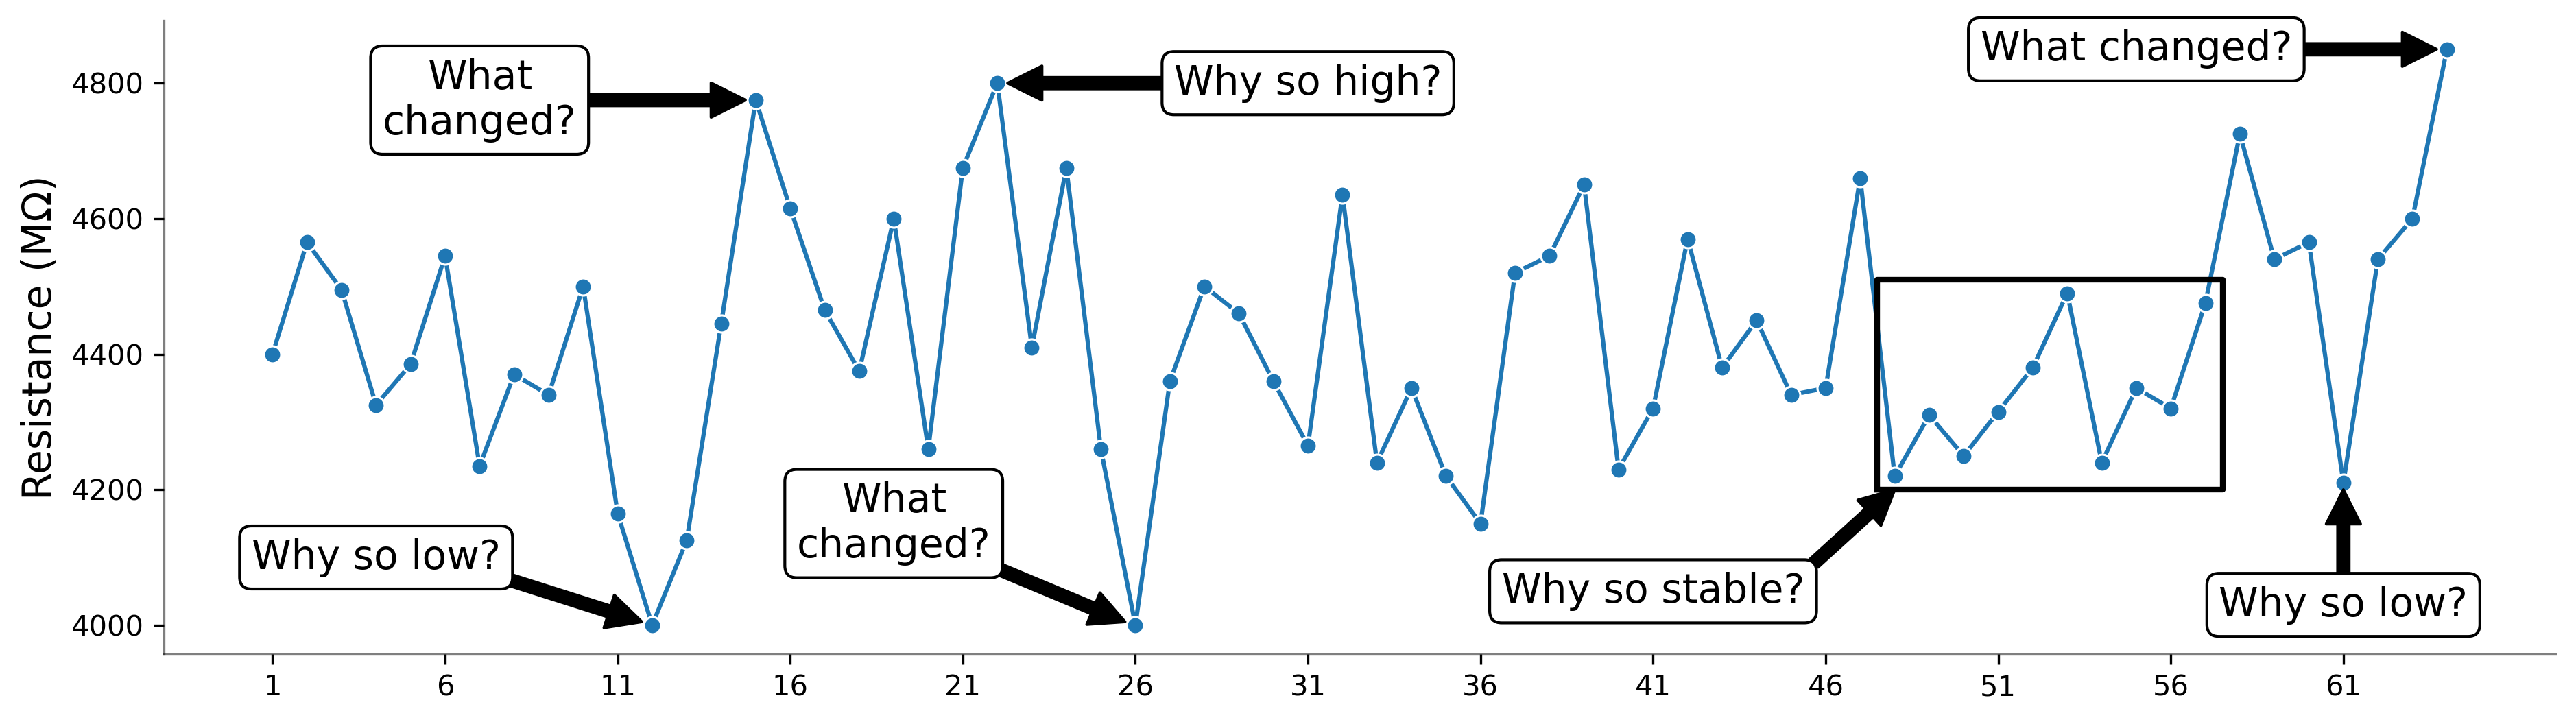

In [41]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15,4), dpi=300)

# Plot data in lineplot
sns.lineplot(additional_df, 
             x='Value', 
             y='Resistance', 
             marker='o')

# Set the x-tick labels with increased intervals
labels = additional_df['Value']
tick_interval = 5
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Why so low?', (10.7,4005), (3,4100)),
    ('What\nchanged?', (24.7,4005), (18,4150)),
    ('What\nchanged?', (13.7,4775), (6,4775)),
    ('Why so high?', (21.3,4800), (30,4800)),
    ('Why so stable?', (47,4200), (40,4050)),
    ('Why so low?', (60,4200), (60,4030)),
    ('What changed?', (62.7,4850), (54,4850))
    ]

# Add annotations using a loop
for text, xy, xytext in annotations:
    ax.annotate(text, xy=xy, xytext=xytext,
                ha='center', 
                va='center', fontsize=14,
                bbox=dict(facecolor='white', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

# Add box for highlighting range of values satisfying Rule 3
start_index = 46.5
end_index = 56.5  
y_min = 4200  
y_max = 4510 

# # Add a border using plt.plot()
ax.plot([start_index, end_index, end_index, start_index, start_index], 
         [y_min, y_min, y_max, y_max, y_min], color='black', linewidth=2)
    
# Despine
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Additional formatting
ax.set_ylabel('Resistance (MΩ)', fontsize=14)
ax.set_xlabel('')
    
# Show plot
plt.show()

## Figure 13.8: XmR chart of resistance measurements

In [42]:
# Specify round_value
round_value = 2

# Disaggregate the dataframe 
data = additional_df["Resistance"]
moving_ranges = round(abs(data.diff()),round_value)
labels = additional_df["Value"]

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = round(max(0,mean - (C1*average_mR)))

if LPL != 0:
    LPL = round(LPL, round_value)

# Calculate the Upper Range Limit
URL = round(C2*average_mR, round_value)

LPL_test = mean - (C1*average_mR)

In [43]:
# Specify tickinterval
tickinterval = 5

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'-','black'), (UPL,'--','tab:red'), (LPL,'--','tab:red')]
mrchart_lines = [(average_mR,'-','black'), (URL,'--','tab:red')]

# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

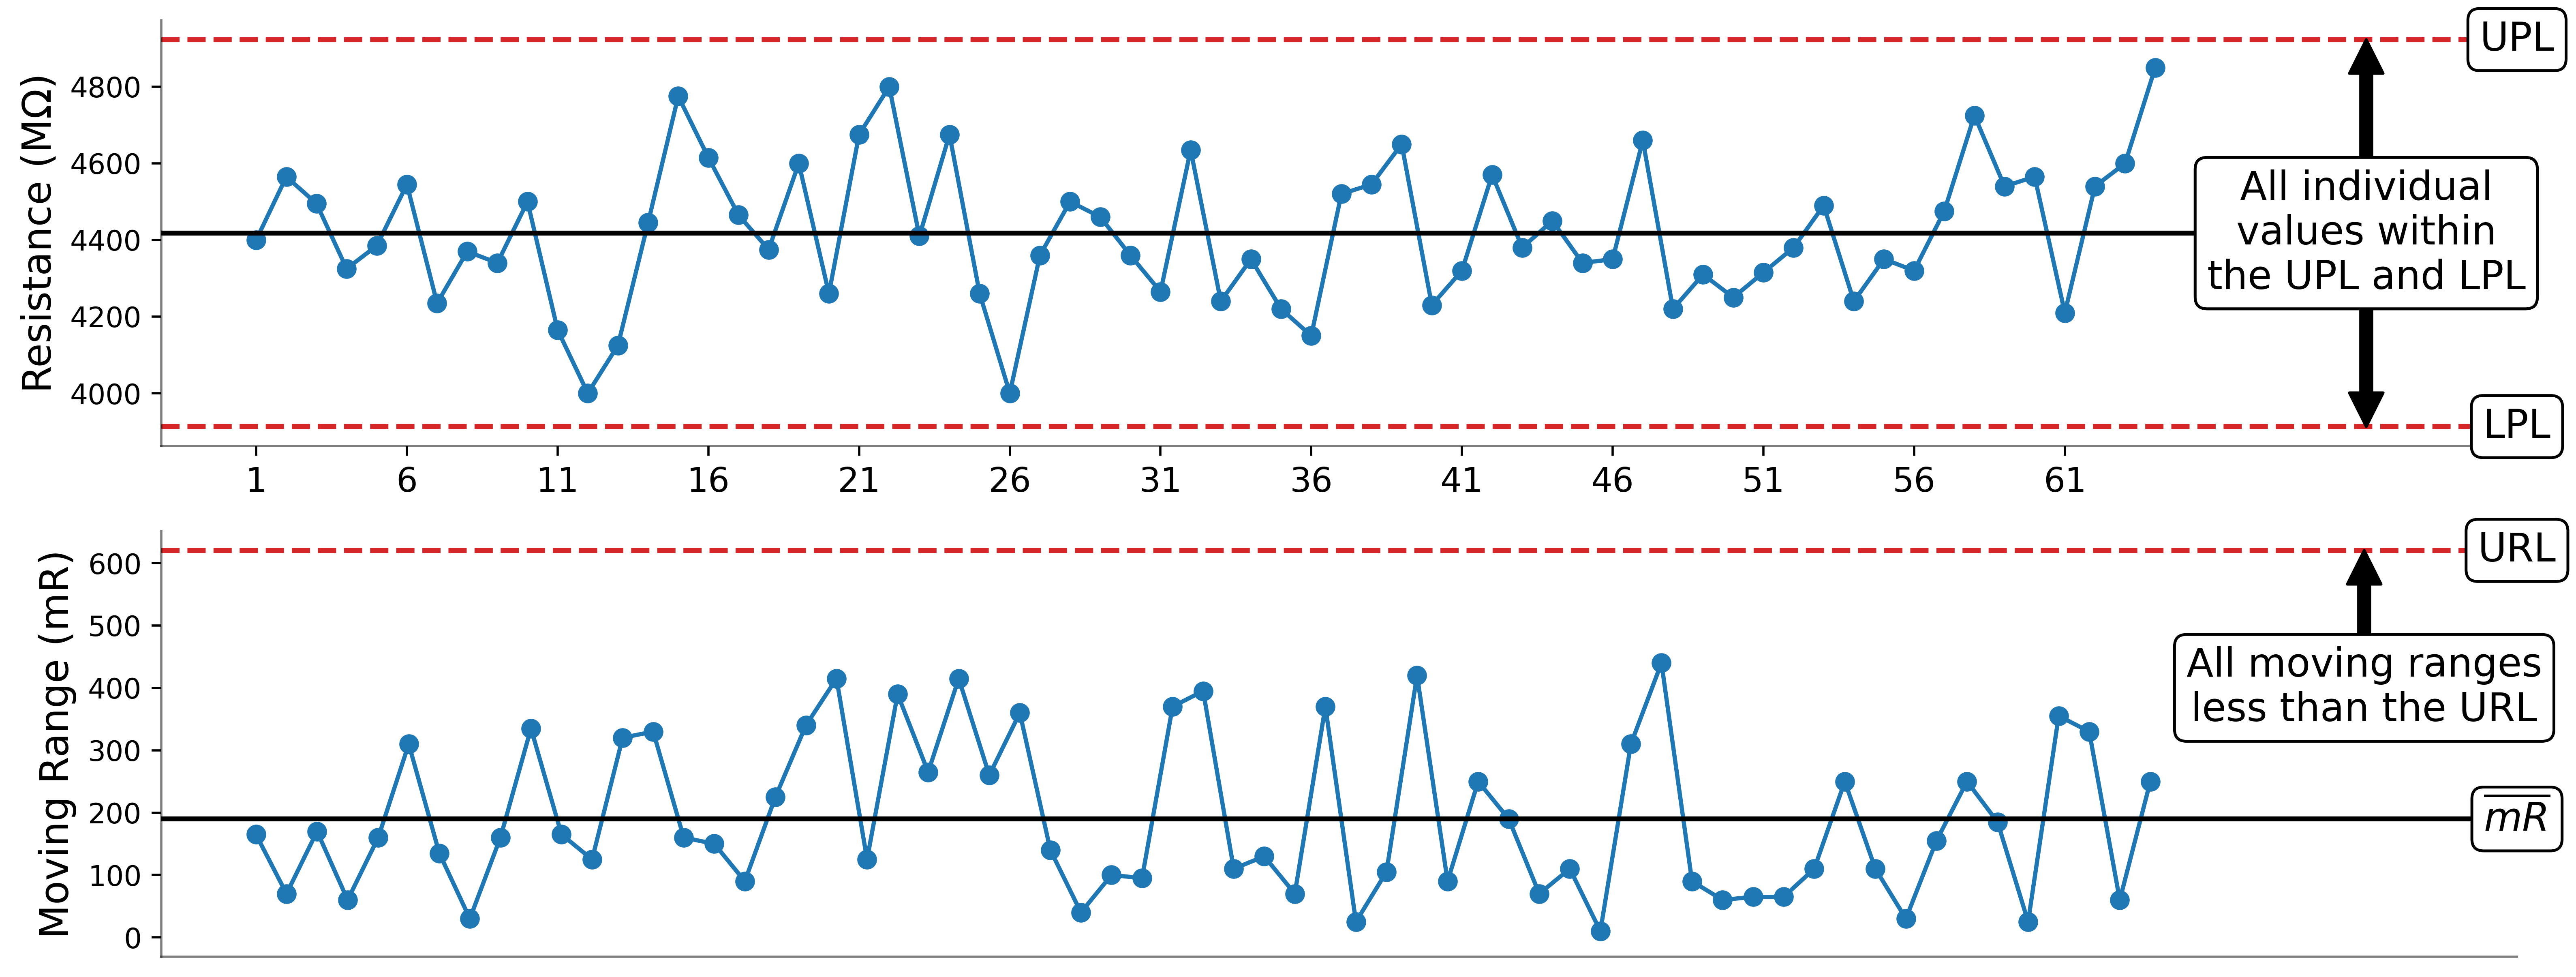

In [44]:
# Create figure and axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6), dpi=500)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
# Add masking parameters to color values greater than URL
axs[1].plot(labels[1:], url_greater[1:], marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Get the new right x-limit after extending the axis
xmax = axs[0].get_xlim()[1]
# Specify location
location = 70

# Extend x-axis to make space for annotations
axs[0].set_xlim(right=location + 5)  # add some padding past the annotation
axs[1].set_xlim(right=location + 5)  # match lower chart to upper

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
# axs[0].text(axs[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
#             fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], average_mR, r'$\overline{mR}$', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, line, color in xchart_lines:
    axs[0].axhline(value, ls=line, c=color, lw=1.75)
    
# Add centerline and process limits 
for value, line, color in mrchart_lines:
    axs[1].axhline(value, ls=line, c=color, lw=1.75)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Resistance (MΩ)", fontsize=14)
axs[0].set_title("", fontsize=14)

axs[1].set_xlabel("")
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)
axs[1].set_xticks([])

# Color values in the moving range white (applies to first value for visual offset)
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0)

# Specify spine visibility 
sns.despine()
for val in (0,1):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Only common\n' 
     'causes of routine\n' 
     'variation present', (location,UPL), (location,mean)),
    ('Only common\n' 
     'causes of routine\n' 
     'variation present', (location,LPL), (location,mean)),
    ]

annotations = [
    ('All individual\n' 
     'values within\n'
     'the UPL and LPL', (location,UPL), (location,mean)),
    ('All individual\n' 
     'values within\n'
     'the UPL and LPL', (location,LPL), (location,mean)),
    ]

# Add annotations using a loop
for text, xy, xytext in annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', 
                va='center', fontsize=14,
                bbox = dict(facecolor='white', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

mr_annotations = [
    ('All moving ranges\n'
     'less than the URL', (location, URL), (location,400))
]

# Add annotations using a loop
for text, xy, xytext in mr_annotations:
    axs[1].annotate(text, xy=xy, xytext=xytext,
                ha='center', 
                va='center', fontsize=14,
                bbox = dict(facecolor='white', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

# Show plot
plt.show()

## Figure 13.9: Run chart with spec limits

In [45]:
# Reduce initial_df to create 'initial_reduced'
initial_reduced = initial_df.iloc[144:177].reset_index(drop=True)

# Drop value column
initial_reduced = initial_reduced.drop('Value', axis=1)

# Add new Value colmun
initial_reduced['Value'] = pd.Series(i for i in range(1,34)).astype('string')

# Show initial_reduced datatypes
initial_reduced.head()

Stage  Resistance Value
0  Initial        4340     1
1  Initial        4340     2
2  Initial        3665     3
3  Initial        3775     4
4  Initial        5000     5

In [46]:
# Specify the spec limits
USL = 5700
LSL = 3550

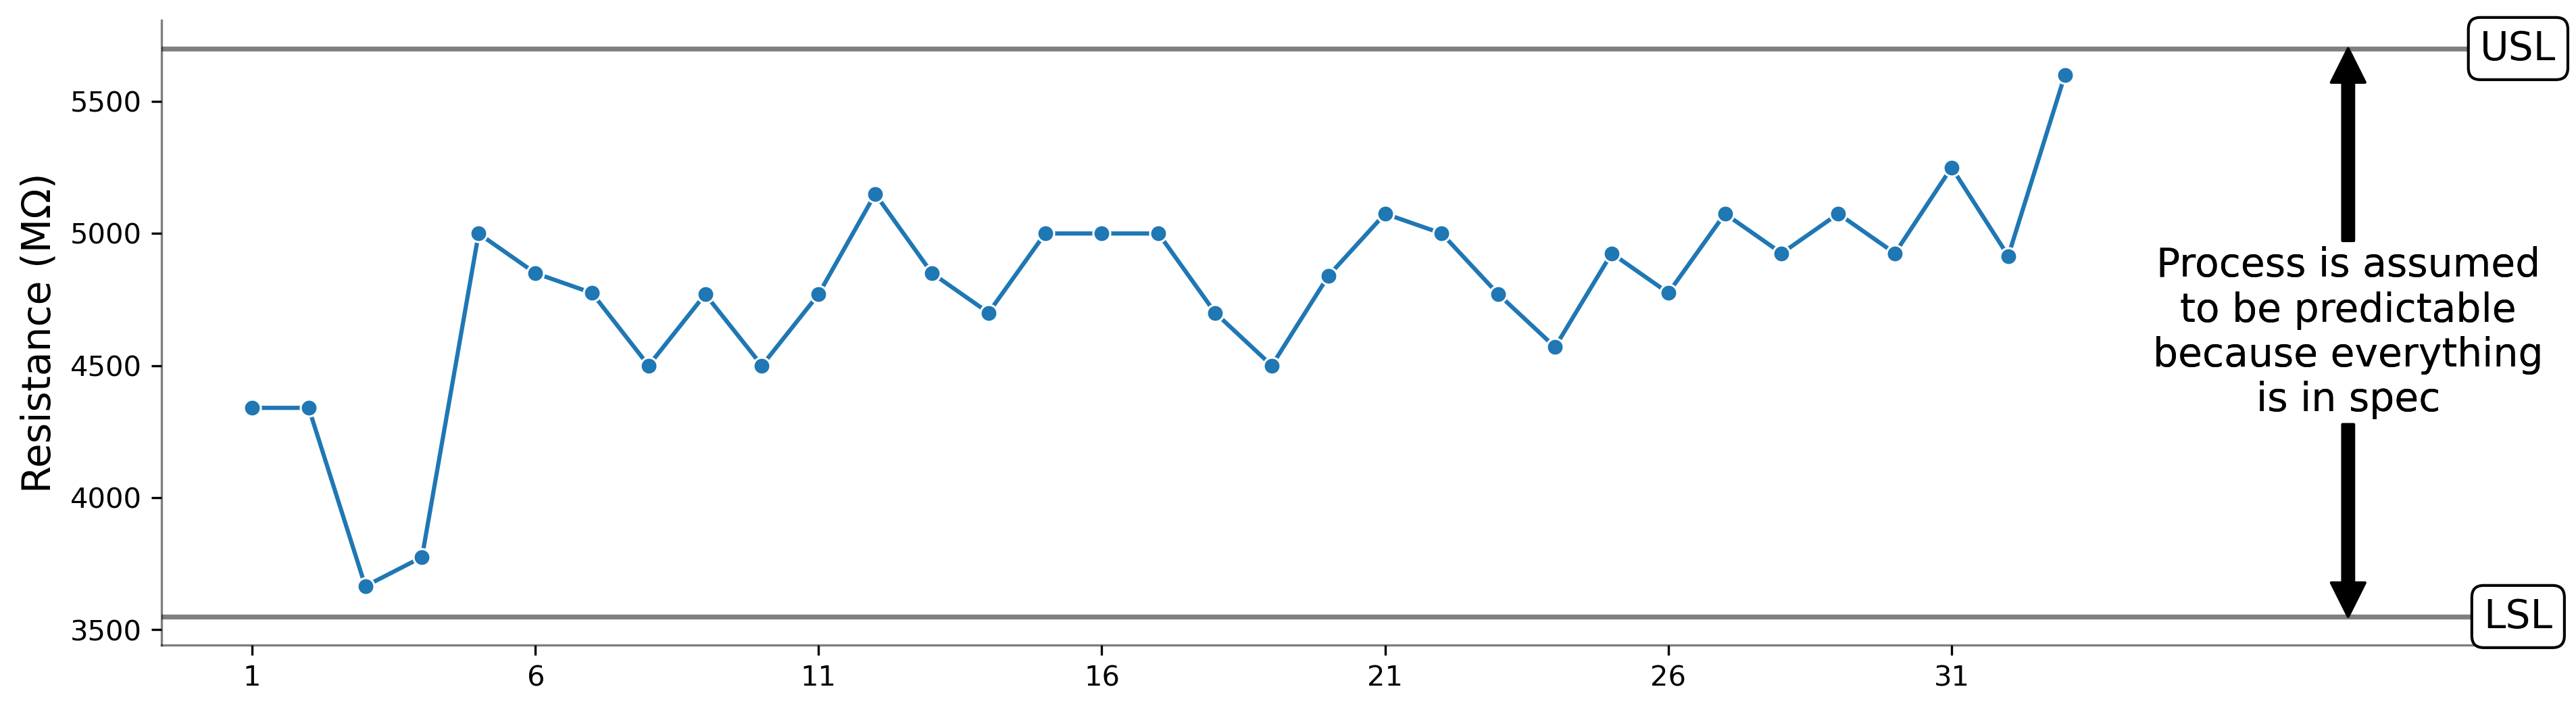

In [47]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15,4), dpi=300)

# Plot data in lineplot
sns.lineplot(initial_reduced, 
             x='Value', 
             y='Resistance', 
             marker='o')

# Set the x-tick labels with increased intervals
labels = pd.Series(np.arange(44))+1
tick_interval = 5
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Hide the last two tick labels 
xticklabels = ax.get_xticklabels()      
for i in range(-2, 0):                   
    xticklabels[i].set_visible(False)   

# Hide the last two tick marks
ticks = ax.xaxis.get_major_ticks() 
for i in range(-2, 0):             
    ticks[i].tick1line.set_visible(False) 
    ticks[i].tick2line.set_visible(False)
    
# Add spec limits
ax.axhline(5700, ls='-', c='grey', lw=1.75)
ax.axhline(3550, ls='-', c='grey', lw=1.75)

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Process is assumed\n' 
     'to be predictable\n' 
     'because everything\n' 
     'is in spec', (37,USL), (37,4625)),
    ('Process is assumed\n' 
     'to be predictable\n' 
     'because everything\n' 
     'is in spec', (37,LSL), (37,4625)),
    ]

# Add annotations using a loop
for text, xy, xytext in annotations:
    ax.annotate(text, xy=xy, xytext=xytext,
                ha='center', 
                va='center', fontsize=14,
                arrowprops=dict(facecolor='black'))

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax.text(ax.get_xlim()[1], USL, 'USL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
ax.text(ax.get_xlim()[1], LSL, 'LSL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
    
# Despine
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Additional formatting
ax.set_ylabel("Resistance (MΩ)", fontsize=14)
ax.set_xlabel('')
    
# Show plot
plt.show()

## Figure 13.10: XmR chart of resistance measurements from Figure 13.9

In [48]:
# Specify round_value
round_value = 2

# Disaggregate the dataframe 
data = initial_reduced["Resistance"]
moving_ranges = round(abs(data.diff()),round_value)
labels = initial_reduced["Value"]

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = round(max(0,mean - (C1*average_mR)))

if LPL != 0:
    LPL = round(LPL, round_value)

# Calculate the Upper Range Limit
URL = round(C2*average_mR, round_value)

LPL_test = mean - (C1*average_mR)

In [49]:
# Specify tickinterval
tickinterval = 5

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'-','black'), (UPL,'--','tab:red'), (LPL,'--','tab:red')]
mrchart_lines = [(average_mR,'-','black'), (URL,'--','tab:red')]

# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

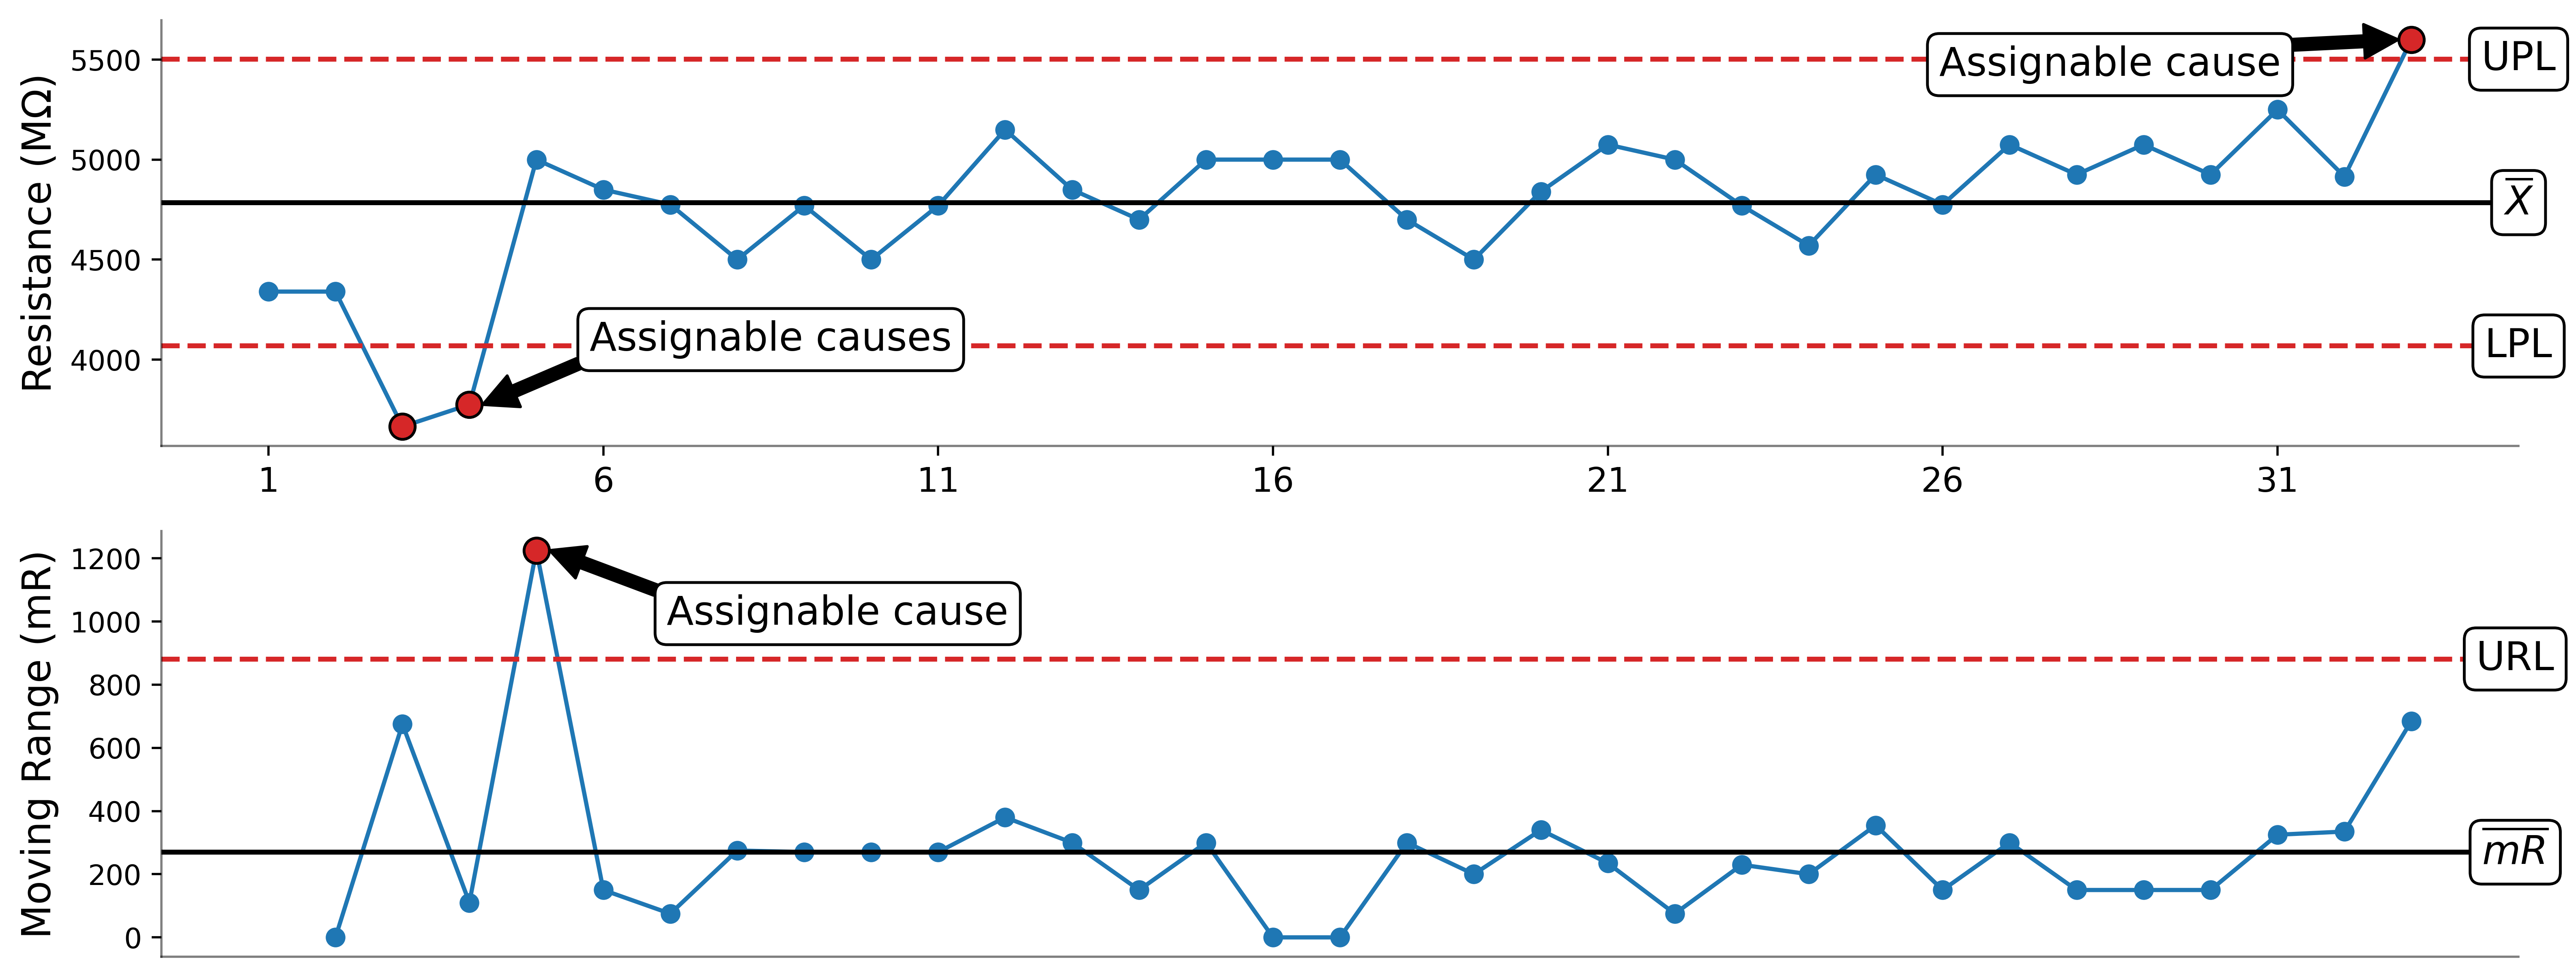

In [50]:
# Create figure and axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6), dpi=500)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
# Add masking parameters to color values greater than URL
axs[1].plot(labels[1:], url_greater[1:], marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

axs[1].text(axs[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], average_mR, r'$\overline{mR}$', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, line, color in xchart_lines:
    axs[0].axhline(value, ls=line, c=color, lw=1.75)
    
# Add centerline and process limits 
for value, line, color in mrchart_lines:
    axs[1].axhline(value, ls=line, c=color, lw=1.75)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Resistance (MΩ)", fontsize=14)
axs[0].set_title("", fontsize=14)

axs[1].set_xlabel("")
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)
axs[1].set_xticks([])

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
x_chart_annotations = [
    ('Assignable causes', (3.2,3775), (7.5,4100)),
    ('Assignable cause', (31.8,5600), (27.5,5475)), 
    
    ]

mr_chart_annotations = [
    ('Assignable cause', (4.2,1225), (8.5,1025))
    ]

# Add annotations using a loop
for text, xy, xytext in x_chart_annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', 
                va='center', fontsize=14,
                bbox=dict(facecolor='white', boxstyle='round'),
                arrowprops=dict(facecolor='black'))
    
for text, xy, xytext in mr_chart_annotations:
    axs[1].annotate(text, xy=xy, xytext=xytext,
                ha='center', 
                va='center', fontsize=14,
                bbox=dict(facecolor='white', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

# Color values in the moving range white (applies to first value for visual offset)
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0)

# Specify spine visibility 
sns.despine()
for val in (0,1):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Show plot
plt.show()